# What do we want to look at? (Larger Areas)


In [1]:
import pandas as pd
import numpy as np
import time,os,sys
from p_tqdm import p_map
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

import sqlite3
sqlite3.register_adapter(np.int64, lambda val: int(val))
sqlite3.register_adapter(np.int32, lambda val: int(val))

from const import DATASETS,SETTINGS

TYPE310 Output_Areas 2001
TYPE299 Output_Areas 2011
TYPE304 Lower_Layer_Super_Output_Areas 2001
TYPE298 Lower_Layer_Super_Output_Areas 2011
TYPE305 Middle_Layer_Super_Output_Areas 2001
TYPE297 Middle_Layer_Super_Output_Areas 2011


In [3]:
areas= gpd.read_file('InputFiles/Counties_and_Unitary_Authorities_(December_2020)_UK_BGC.geojson')
code = filter(lambda x: x[-2:]=='CD',areas.columns).__next__()



In [4]:
# def get_centroids(kind):
areatype = 'Output_Areas'    
if 'Areas' in sys.argv[1]:
    areatype = sys.argv[1]

__outdir__='flatdb/'+areatype
try:os.mkdir(__outdir__)
except:pass

areatype

'Output_Areas'

In [22]:


cdf = pd.DataFrame()
for y in SETTINGS.years:
    f = SETTINGS.matchC(areatype,y)
    print(f)
    dummy = pd.read_csv(f)
    dummy['YEAR'] = int(y)
    # dummy.columns = ['AREACD' if 'cd' in x.lower() else x for x in dummy.columns]
    cdf = pd.concat([cdf, dummy ],axis=0)# df.append(process_df(url,src))

cdf.columns = 'AREACD LAT LON YEAR'.split()

# Lets take the mean centroid of unchaged areas since STDS are small
# GROUP BY AREACD - why we can do this was shown below
cdf = cdf.groupby('AREACD').mean().astype(np.int32).reset_index()

cdf['GEOGRAPHY_CODE'] = cdf.index.astype(np.int32)
print(cdf)


# cdf = cdf.astype({'AREACD': str,
#             'LAT': np.int32,
#             'LON': np.int32,
#             'YEAR': np.int32,
#             'GEOGRAPHY_CODE': np.int32})

geomap = dict(zip(cdf.AREACD,cdf.GEOGRAPHY_CODE))
# 



./centroids/WGS84_simplified/Output_Areas__December_2001__Population_Weighted_Centroids.csv
./centroids/WGS84_simplified/Output_Areas__December_2011__Population_Weighted_Centroids.csv
           AREACD      LAT     LON  YEAR  GEOGRAPHY_CODE
0       E00000001  5152026   -9493  2006               0
1       E00000002  5151835   -9726  2001               1
2       E00000003  5151988   -9677  2006               2
3       E00000004  5151995   -9545  2001               3
4       E00000005  5151920   -9637  2006               4
...           ...      ...     ...   ...             ...
185972  W00010261  5165251 -399490  2011          185972
185973  W00010262  5165448 -398440  2011          185973
185974  W00010263  5165256 -399262  2011          185974
185975  W00010264  5166837 -389898  2011          185975
185976  W00010265  5161747 -393661  2011          185976

[185977 rows x 5 columns]


# Now we can apply some corrections: 
-  as all numbers are scaled by 1e5, statistically the std is also scaled by this much. We therefore correct for this. 
-  Length in meters of 1° of latitude = always 111.32 km
-  Length in meters of 1° of longitude = 40075 km * cos( latitude ) / 360

100%|██████████| 185977/185977 [01:41<00:00, 1838.06it/s]


array([<AxesSubplot:xlabel='AREACD'>, <AxesSubplot:xlabel='AREACD'>,
       <AxesSubplot:xlabel='AREACD'>], dtype=object)

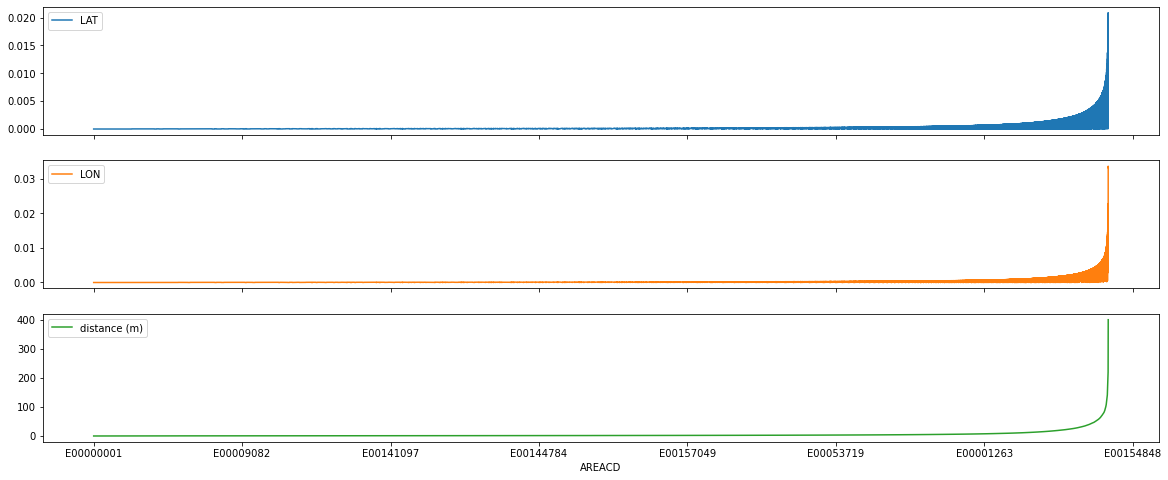

In [220]:
'''
# To use this uncomment the grouping above. 

# as all numbers are scaled by 1e5, statistically the std is also scaled by this much. We therefore correct for this. 
std = (cdf.groupby('AREACD')['LAT LON'.split()].std()/1e5)


def distance(item):
    # assuming that the Earth is a sphere with a circumference of 40075 km.
    lat,lon = item
    x = lon*4007500*np.cos(lat)/360
    y = 11132*lat
    return np.sqrt(x**2+y**2)


std['distance (m)'] = p_map(distance,std.values)
std.sort_values('distance (m)').plot(label='means',subplots=True)


'''

In [23]:

pts = [Point(p[1].LON/1e5,p[1].LAT/1e5) for p in list(cdf.iterrows())]
cdf['pts'] = pts
cdf

,AREACD,LAT,LON,YEAR,GEOGRAPHY_CODE,pts
0,E00000001,5152026,-9493,2006,0,POINT (-0.09493 51.52026)
1,E00000002,5151835,-9726,2001,1,POINT (-0.09726 51.51835)
2,E00000003,5151988,-9677,2006,2,POINT (-0.09676999999999999 51.51988)
3,E00000004,5151995,-9545,2001,3,POINT (-0.09544999999999999 51.51995)
4,E00000005,5151920,-9637,2006,4,POINT (-0.09637 51.5192)
...,...,...,...,...,...,...
185972,W00010261,5165251,-399490,2011,185972,POINT (-3.9949 51.65251)
185973,W00010262,5165448,-398440,2011,185973,POINT (-3.9844 51.65448)
185974,W00010263,5165256,-399262,2011,185974,POINT (-3.99262 51.65256)
185975,W00010264,5166837,-389898,2011,185975,POINT (-3.89898 51.66837)


In [24]:
# cdf.PARENT = [ '' for i in range(len(cdf))]
# clen = len(cdf)


def get_parent(p1):
    # p1 = Point(p[1].LON/1e5,p[1].LAT/1e5)
    for g in areas.iterrows():
        if p1.within(g[1].geometry):
            return g[1][code]


parents = p_map(get_parent,pts)
            

# this takes ~hour in serial with implace replacement Avoid! 
    

100%|██████████| 185977/185977 [03:13<00:00, 963.14it/s] 


In [25]:
cdf['PARENTS'] = parents
cdf.head()

,AREACD,LAT,LON,YEAR,GEOGRAPHY_CODE,pts,PARENTS
0,E00000001,5152026,-9493,2006,0,POINT (-0.09493 51.52026),E09000001
1,E00000002,5151835,-9726,2001,1,POINT (-0.09726 51.51835),E09000001
2,E00000003,5151988,-9677,2006,2,POINT (-0.09676999999999999 51.51988),E09000001
3,E00000004,5151995,-9545,2001,3,POINT (-0.09544999999999999 51.51995),E09000001
4,E00000005,5151920,-9637,2006,4,POINT (-0.09637 51.5192),E09000001


In [26]:
with_values = cdf[cdf.PARENTS.notnull()]['AREACD YEAR PARENTS LAT LON'.split()]
with_values = with_values.reset_index()
with_values.columns = 'AREACD AREAID YEAR PARENTS LAT LON'.split()
with_values= with_values.groupby('PARENTS AREAID AREACD'.split()).mean()
with_values

YEAR        LAT       LON
PARENTS   AREAID    AREACD                             
E06000001 E00060255 60254   2006.0  5467687.0 -121859.0
          E00060256 60255   2006.0  5467313.0 -122734.0
          E00060257 60256   2006.0  5467282.0 -123211.0
          E00060258 60257   2006.0  5467866.0 -121791.0
          E00060259 60258   2006.0  5467858.0 -121919.0
...                            ...        ...       ...
W06000024 W00006942 182682  2006.0  5176987.0 -340021.0
          W00009771 185511  2011.0  5179261.0 -336860.0
          W00010109 185820  2011.0  5174955.0 -336444.0
          W00010110 185821  2011.0  5174687.0 -336503.0
          W00010111 185822  2011.0  5174959.0 -336713.0

[185944 rows x 3 columns]

In [27]:
__outdir__='flatdb/'+areatype
try: os.mkdir(__outdir__)
except: None

with_values.to_csv(__outdir__+'/mapping.csv',index=True)

In [28]:
tally = with_values.groupby('PARENTS').count().mean(axis=1).sort_values()
tally

PARENTS
E06000053       8.0
E09000001      41.0
E06000017     120.0
W06000024     191.0
W06000001     232.0
              ...  
E10000030    3651.0
E10000017    3967.0
E10000014    4348.0
E10000012    4692.0
E10000016    4760.0
Length: 173, dtype: float64

<Figure size 1440x1080 with 0 Axes>

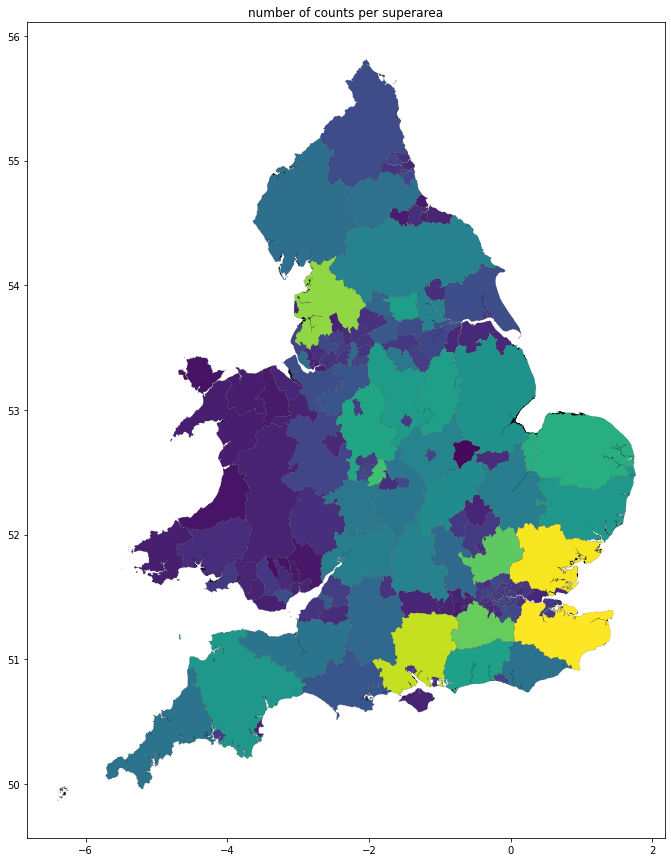

In [31]:
import matplotlib.pyplot as plt

def counts(x):
    try:return tally.loc[x]
    except:return np.nan

areas['counts'] = areas[code].map(counts)
# areas['counts'] = areas['counts']/max(areas['counts'])

plt.figure(figsize=(20,15))
plt.rcParams['figure.figsize'] = [20, 15]
areas.plot(column='counts',cmap='viridis',edgecolor='k',linewidth=0.1)
plt.title('number of counts per superarea')
# plt.legend()
plt.savefig('flatdb/'+areatype+'/counts.png')
# plt.show()

In [146]:
# !conda install -c conda-forge descartes --yes


## Finally lets create the mapping Databas

Reading from js can be accomplisehd by 
```
//python
//bytes = np.array([2999499,334534434],dtype=np.int32).tobytes() 
//print(bytes)

str = <bytes>

bytes = Uint8Array.from(str, c => c.charCodeAt(0))
floats = new Int32Array(bytes.buffer)

console.log(floats)
console.log([...floats])

In [86]:
childlist = cdf.groupby('PARENTS')['AREACD'].apply(lambda x: sqlite3.Binary(np.array([geomap[y] for y in x],dtype=np.int32).tobytes()))

db_file = f'{__outdir__}/areainfo.db'
os.system(f'rm {db_file}')
conn = sqlite3.connect(db_file)
childlist.to_sql('children', con=conn, if_exists='replace',index_label='PARENTS')
conn.close()

print(db_file,'children')


flatdb/Output_Areas/areainfo.db children


b'\xcb\xc4-\x00"\x97\xf0\x13'